In [14]:
# !rm -r lfw-py

In [15]:
# %cp -av celeba /content/drive/MyDrive/Dataset/celeba

In [16]:
# from google.colab import drive
# drive.mount('/content/drive')

In [17]:
import torch
import torch.nn.functional as F
from torchvision import transforms
from torch.utils.data import DataLoader, Subset
import numpy as np
import torchvision
import matplotlib.pyplot as plt
import random

In [18]:
import torch.nn.functional as F

def linear_beta_schedule(timesteps, start=0.0001, end=0.02):
    return torch.linspace(start, end, timesteps)

def get_index_from_list(vals, t, x_shape):
    """
    Returns a specific index t of a passed list of values vals
    while considering the batch dimension.
    """
    batch_size = t.shape[0]
    out = vals.gather(-1, t.cpu())
    return out.reshape(batch_size, *((1,) * (len(x_shape) - 1))).to(t.device)

def forward_diffusion_sample(x_0, t, device="cpu"):
    """
    Takes an image and a timestep as input and
    returns the noisy version of it
    """
    noise = torch.randn_like(x_0)
    sqrt_alphas_cumprod_t = get_index_from_list(sqrt_alphas_cumprod, t, x_0.shape)
    sqrt_one_minus_alphas_cumprod_t = get_index_from_list(
        sqrt_one_minus_alphas_cumprod, t, x_0.shape
    )
    # mean + variance
    return sqrt_alphas_cumprod_t.to(device) * x_0.to(device) \
    + sqrt_one_minus_alphas_cumprod_t.to(device) * noise.to(device), noise.to(device)


# Define beta schedule
T = 300
betas = linear_beta_schedule(timesteps=T)

# Pre-calculate different terms for closed form
alphas = 1. - betas
alphas_cumprod = torch.cumprod(alphas, axis=0)
alphas_cumprod_prev = F.pad(alphas_cumprod[:-1], (1, 0), value=1.0)
sqrt_recip_alphas = torch.sqrt(1.0 / alphas)
sqrt_alphas_cumprod = torch.sqrt(alphas_cumprod)
sqrt_one_minus_alphas_cumprod = torch.sqrt(1. - alphas_cumprod)
posterior_variance = betas * (1. - alphas_cumprod_prev) / (1. - alphas_cumprod)

In [19]:
IMG_SIZE = 64
BATCH_SIZE = 128
PATH = "."
def load_transformed_dataset():
    data_transforms = [
        transforms.Resize((IMG_SIZE, IMG_SIZE)),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(), # Scales data into [0,1]
        transforms.Lambda(lambda t: (t * 2) - 1) # Scale between [-1, 1]
    ]
    data_transform = transforms.Compose(data_transforms)

    dataset = torchvision.datasets.Flowers102(root=PATH, download=True,
                                         transform=data_transform, split='test')

    total_samples = len(dataset)
    subset_size = int(0.5 * total_samples)

    # Randomly select a subset of indices
    subset_indices = random.sample(range(total_samples), subset_size)

    # Create the subset
    subset = Subset(dataset, subset_indices)
    return dataset
def show_tensor_image(image):
    reverse_transforms = transforms.Compose([
        transforms.Lambda(lambda t: (t + 1) / 2),
        transforms.Lambda(lambda t: t.permute(1, 2, 0)), # CHW to HWC
        transforms.Lambda(lambda t: t * 255.),
        transforms.Lambda(lambda t: t.numpy().astype(np.uint8)),
        transforms.ToPILImage(),
    ])

    # Take first image of batch
    if len(image.shape) == 4:
        image = image[0, :, :, :]
    plt.imshow(reverse_transforms(image))

data = load_transformed_dataset()
dataloader = DataLoader(data, batch_size=BATCH_SIZE, shuffle=True, drop_last=True)

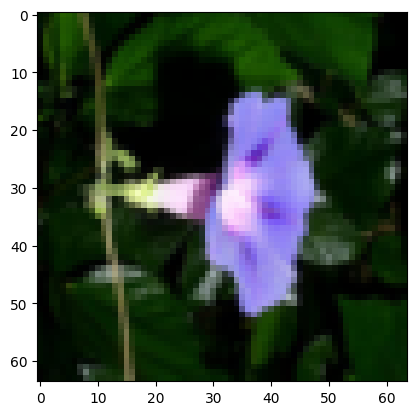

In [20]:
image = iter(dataloader)
image = image._next_data()[0]
show_tensor_image(image)

<ipython-input-21-f4853fe96c6f>:11: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  plt.subplot(1, num_images+1, int(idx/stepsize) + 1)


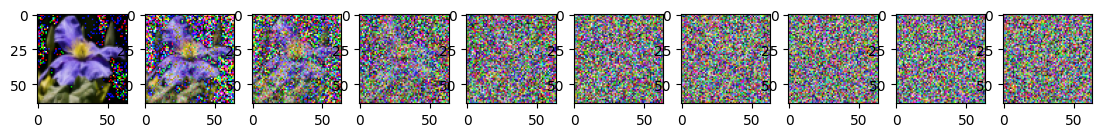

In [21]:
# Simulate forward diffusion
image = next(iter(dataloader))[0]

plt.figure(figsize=(15,15))
plt.axis('off')
num_images = 10
stepsize = int(T/num_images)

for idx in range(0, T, stepsize):
    t = torch.Tensor([idx]).type(torch.int64)
    plt.subplot(1, num_images+1, int(idx/stepsize) + 1)
    img, noise = forward_diffusion_sample(image, t)
    show_tensor_image(img)

In [22]:
from torch import nn
import math


class Block(nn.Module):
    def __init__(self, in_ch, out_ch, time_emb_dim, up=False):
        super().__init__()
        self.time_mlp =  nn.Linear(time_emb_dim, out_ch)
        if up:
            self.conv1 = nn.Conv2d(2*in_ch, out_ch, 3, padding=1)
            self.transform = nn.ConvTranspose2d(out_ch, out_ch, 4, 2, 1)
        else:
            self.conv1 = nn.Conv2d(in_ch, out_ch, 3, padding=1)
            self.transform = nn.Conv2d(out_ch, out_ch, 4, 2, 1)
        self.conv2 = nn.Conv2d(out_ch, out_ch, 3, padding=1)
        self.bnorm1 = nn.BatchNorm2d(out_ch)
        self.bnorm2 = nn.BatchNorm2d(out_ch)
        self.relu  = nn.ReLU()

    def forward(self, x, t, ):
        # First Conv
        h = self.bnorm1(self.relu(self.conv1(x)))
        # Time embedding
        time_emb = self.relu(self.time_mlp(t))
        # Extend last 2 dimensions
        time_emb = time_emb[(..., ) + (None, ) * 2]
        # Add time channel
        h = h + time_emb
        # Second Conv
        h = self.bnorm2(self.relu(self.conv2(h)))
        # Down or Upsample
        return self.transform(h)


class SinusoidalPositionEmbeddings(nn.Module):
    def __init__(self, dim):
        super().__init__()
        self.dim = dim

    def forward(self, time):
        device = time.device
        half_dim = self.dim // 2
        embeddings = math.log(10000) / (half_dim - 1)
        embeddings = torch.exp(torch.arange(half_dim, device=device) * -embeddings)
        embeddings = time[:, None] * embeddings[None, :]
        embeddings = torch.cat((embeddings.sin(), embeddings.cos()), dim=-1)
        # TODO: Double check the ordering here
        return embeddings


class SimpleUnet(nn.Module):
    """
    A simplified variant of the Unet architecture.
    """
    def __init__(self):
        super().__init__()
        image_channels = 3
        down_channels = (64, 128, 256, 512, 1024)
        up_channels = (1024, 512, 256, 128, 64)
        out_dim = 3
        time_emb_dim = 32

        # Time embedding
        self.time_mlp = nn.Sequential(
                SinusoidalPositionEmbeddings(time_emb_dim),
                nn.Linear(time_emb_dim, time_emb_dim),
                nn.ReLU()
            )

        # Initial projection
        self.conv0 = nn.Conv2d(image_channels, down_channels[0], 3, padding=1)

        # Downsample
        self.downs = nn.ModuleList([Block(down_channels[i], down_channels[i+1], \
                                    time_emb_dim) \
                    for i in range(len(down_channels)-1)])
        # Upsample
        self.ups = nn.ModuleList([Block(up_channels[i], up_channels[i+1], \
                                        time_emb_dim, up=True) \
                    for i in range(len(up_channels)-1)])

        # Edit: Corrected a bug found by Jakub C (see YouTube comment)
        self.output = nn.Conv2d(up_channels[-1], out_dim, 1)

    def forward(self, x, timestep):
        # Embedd time
        t = self.time_mlp(timestep)
        # Initial conv
        x = self.conv0(x)
        # Unet
        residual_inputs = []
        for down in self.downs:
            x = down(x, t)
            residual_inputs.append(x)
        for up in self.ups:
            residual_x = residual_inputs.pop()
            # Add residual x as additional channels
            x = torch.cat((x, residual_x), dim=1)
            x = up(x, t)
        return self.output(x)

model = SimpleUnet()
print("Num params: ", sum(p.numel() for p in model.parameters()))
model

Num params:  62438883


SimpleUnet(
  (time_mlp): Sequential(
    (0): SinusoidalPositionEmbeddings()
    (1): Linear(in_features=32, out_features=32, bias=True)
    (2): ReLU()
  )
  (conv0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (downs): ModuleList(
    (0): Block(
      (time_mlp): Linear(in_features=32, out_features=128, bias=True)
      (conv1): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (transform): Conv2d(128, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
      (conv2): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (bnorm1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (bnorm2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU()
    )
    (1): Block(
      (time_mlp): Linear(in_features=32, out_features=256, bias=True)
      (conv1): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (transfor

In [23]:
def get_loss(model, x_0, t):
    x_noisy, noise = forward_diffusion_sample(x_0, t, device)
    noise_pred = model(x_noisy, t)
    return F.l1_loss(noise, noise_pred)

In [24]:
@torch.no_grad()
def sample_timestep(x, t):
    """
    Calls the model to predict the noise in the image and returns
    the denoised image.
    Applies noise to this image, if we are not in the last step yet.
    """
    betas_t = get_index_from_list(betas, t, x.shape)
    sqrt_one_minus_alphas_cumprod_t = get_index_from_list(
        sqrt_one_minus_alphas_cumprod, t, x.shape
    )
    sqrt_recip_alphas_t = get_index_from_list(sqrt_recip_alphas, t, x.shape)

    # Call model (current image - noise prediction)
    model_mean = sqrt_recip_alphas_t * (
        x - betas_t * model(x, t) / sqrt_one_minus_alphas_cumprod_t
    )
    posterior_variance_t = get_index_from_list(posterior_variance, t, x.shape)

    if t == 0:
        # As pointed out by Luis Pereira (see YouTube comment)
        # The t's are offset from the t's in the paper
        return model_mean
    else:
        noise = torch.randn_like(x)
        return model_mean + torch.sqrt(posterior_variance_t) * noise

@torch.no_grad()
def sample_plot_image():
    # Sample noise
    img_size = IMG_SIZE
    img = torch.randn((1, 3, img_size, img_size), device=device)
    plt.figure(figsize=(15,15))
    plt.axis('off')
    num_images = 10
    stepsize = int(T/num_images)

    for i in range(0,T)[::-1]:
        t = torch.full((1,), i, device=device, dtype=torch.long)
        img = sample_timestep(img, t)
        # Edit: This is to maintain the natural range of the distribution
        img = torch.clamp(img, -1.0, 1.0)
        if i % stepsize == 0:
            plt.subplot(1, num_images, int(i/stepsize)+1)
            show_tensor_image(img.detach().cpu())
    plt.show()

0.271354079246521
Epoch 0 | step 000 Loss: 0.271354079246521 


<ipython-input-24-5fbd7b74e2b8>:44: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  plt.subplot(1, num_images, int(i/stepsize)+1)


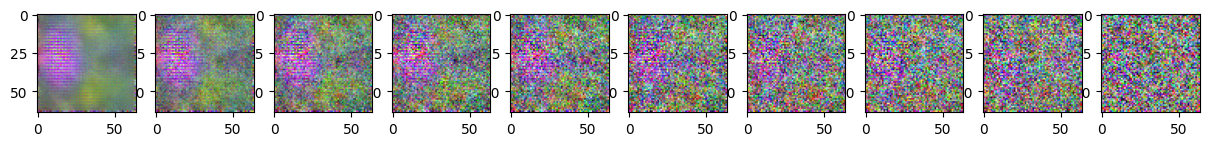

0.25331315398216250.25246652960777280.224548146128654480.240686699748039250.24242113530635834
0.22470894455909730.205583304166793820.22146753966808320.19779217243194580.20249256491661072
0.204385250806808470.222158879041671750.204554662108421330.204527467489242550.21285566687583923
0.212546825408935550.196264714002609250.20262336730957030.208478555083274840.18900422751903534
0.172795698046684270.187389999628067020.184432893991470340.181248590350151060.18004868924617767
Epoch 5 | step 000 Loss: 0.18004868924617767 


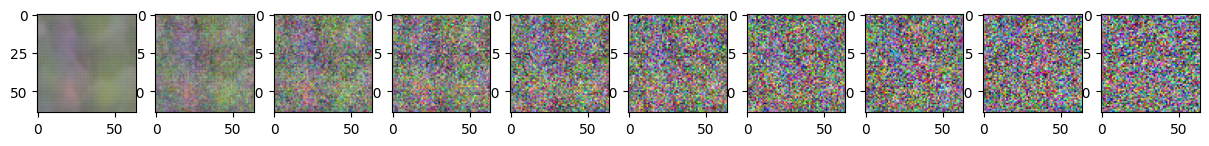

0.170638173818588260.180577725172042850.180696353316307070.187733337283134460.19302210211753845
0.19414579868316650.182051464915275570.18652002513408660.170334517955780030.1860523670911789
0.17508685588836670.18616960942745210.18214830756187440.183790713548660280.18528127670288086
0.168672889471054080.179996967315673830.178900226950645450.174482166767120360.19537828862667084
0.165278494358062740.172493249177932740.165577128529548650.16988991200923920.17979972064495087
Epoch 10 | step 000 Loss: 0.17979972064495087 


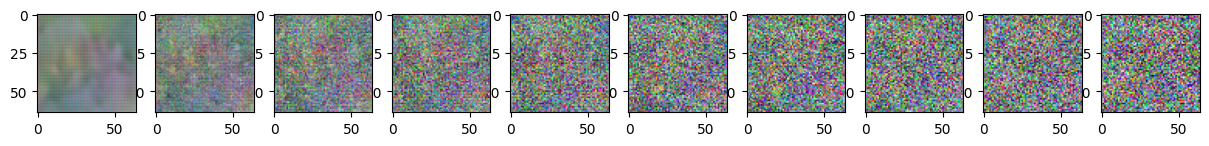

0.198820948600769040.179678678512573240.17461431026458740.16835606098175050.18681327998638153
0.174903139472007750.178327441215515140.184024542570114140.169760152697563170.17149226367473602
0.16269960999488830.17096893489360810.188293039798736570.172484755516052250.16730108857154846
0.18262808024883270.174747139215469360.18295386433601380.197837814688682560.17931720614433289
0.180550098419189450.16157510876655580.177110597491264340.183981597423553470.17107927799224854
Epoch 15 | step 000 Loss: 0.17107927799224854 


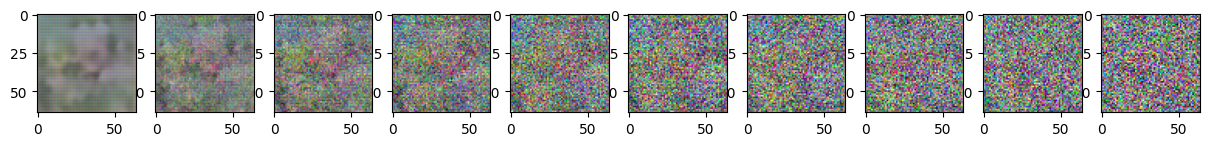

0.174425527453422550.19246420264244080.166919916868209840.182482123374938960.15710723400115967
0.178265452384948730.16792541742324830.17128598690032960.163864552974700930.1787908673286438
0.18514335155487060.167682528495788570.191641330718994140.17101714015007020.15562483668327332
0.16954909265041350.174738407135009770.171086251735687260.16512721776962280.1652209758758545
0.16258552670478820.180697605013847350.15769398212432860.162770643830299380.17559091746807098
Epoch 20 | step 000 Loss: 0.17559091746807098 


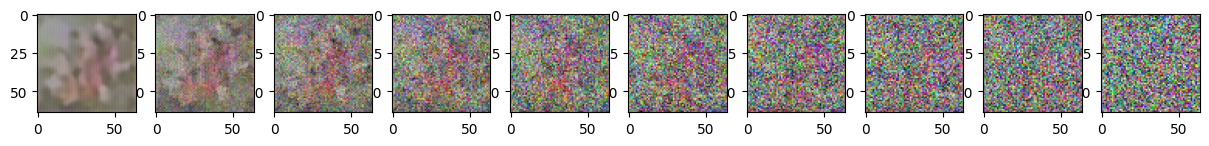

0.16969859600067140.185891091823577880.186499506235122680.175993487238883970.17272035777568817
0.169322058558464050.16802105307579040.166549012064933780.18193536996841430.17279821634292603
0.16403125226497650.164164811372756960.169705674052238460.142347902059555050.15893647074699402
0.166332781314849850.16462320089340210.16663204133510590.159999638795852660.16070230305194855
0.149744823575019840.156240761280059810.155025839805603030.180852383375167850.1630689799785614
Epoch 25 | step 000 Loss: 0.1630689799785614 


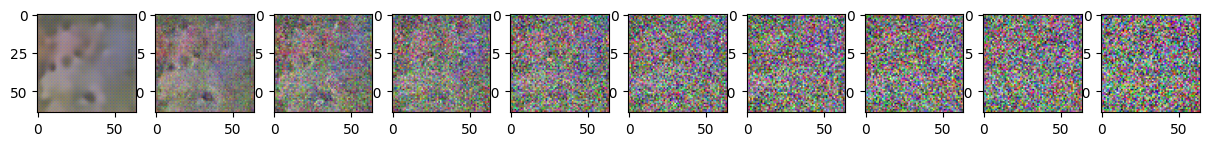

0.185167938470840450.187027081847190860.15742975473403930.16699919104576110.19300679862499237
0.175963684916496280.178809091448783870.16787695884704590.18168202042579650.1587575078010559
0.156783729791641240.16155207157135010.172076791524887080.157993018627166750.16005226969718933
0.17474994063377380.180508524179458620.162855774164199830.162022709846496580.15940982103347778
0.155362620949745180.16399227082729340.147097483277320860.15695992112159730.19053994119167328
Epoch 30 | step 000 Loss: 0.19053994119167328 


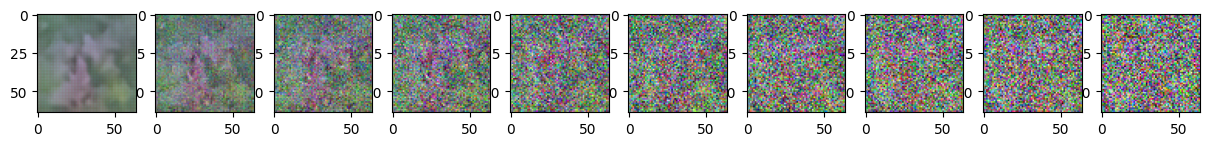

0.164754062891006470.160969048738479610.16418990492820740.157155424356460570.17687968909740448
0.156207427382469180.16332980990409850.166908979415893550.176857158541679380.17549537122249603
0.154186785221099850.156921565532684330.167963072657585140.175091311335563660.16291871666908264
0.15943473577499390.156020984053611760.172203809022903440.157172873616218570.168521910905838
0.162918716669082640.160002887248992920.153640091419219970.204438552260398860.16693362593650818
Epoch 35 | step 000 Loss: 0.16693362593650818 


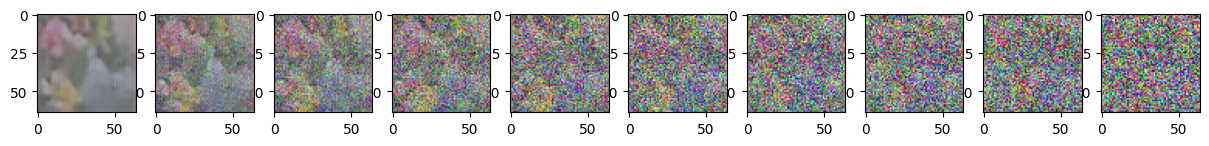

0.14786374568939210.15958714485168457

KeyboardInterrupt: 

In [27]:
from torch.optim import Adam

device = "cuda" if torch.cuda.is_available() else "cpu"
model.to(device)
optimizer = Adam(model.parameters(), lr=0.001)
epochs = 100 # Try more!

for epoch in range(epochs):
    for step, batch in enumerate(dataloader):
      optimizer.zero_grad()

      t = torch.randint(0, T, (BATCH_SIZE,), device=device).long()
      loss = get_loss(model, batch[0], t)
      loss.backward()
      optimizer.step()
      if step % 10 == 0:
        print(loss.item(), end="")
      if step % 100 == 0:
        print()
      if epoch % 5 == 0 and step == 0:
        print(f"Epoch {epoch} | step {step:03d} Loss: {loss.item()} ")
        sample_plot_image()